In [1]:
get_ipython().magic('matplotlib inline')
get_ipython().magic('config InlineBackend.figure_format = "retina"')

import matplotlib.pyplot as pl

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import os
import sys
import numpy as np
import pandas as pd
from scipy import stats
from configobj import ConfigObj
from astropy import constants as c
from astropy import units as u
import pprint

import limbdark

pp = pprint.PrettyPrinter(indent=2)

def map_int(x):
    return list(map(int, x))

def map_float(x):
    return list(map(float, x))

sys.path.append('..')
from transitfit import TransitFit
from transitfit.util import mad_outliers, get_init_params, u_to_q

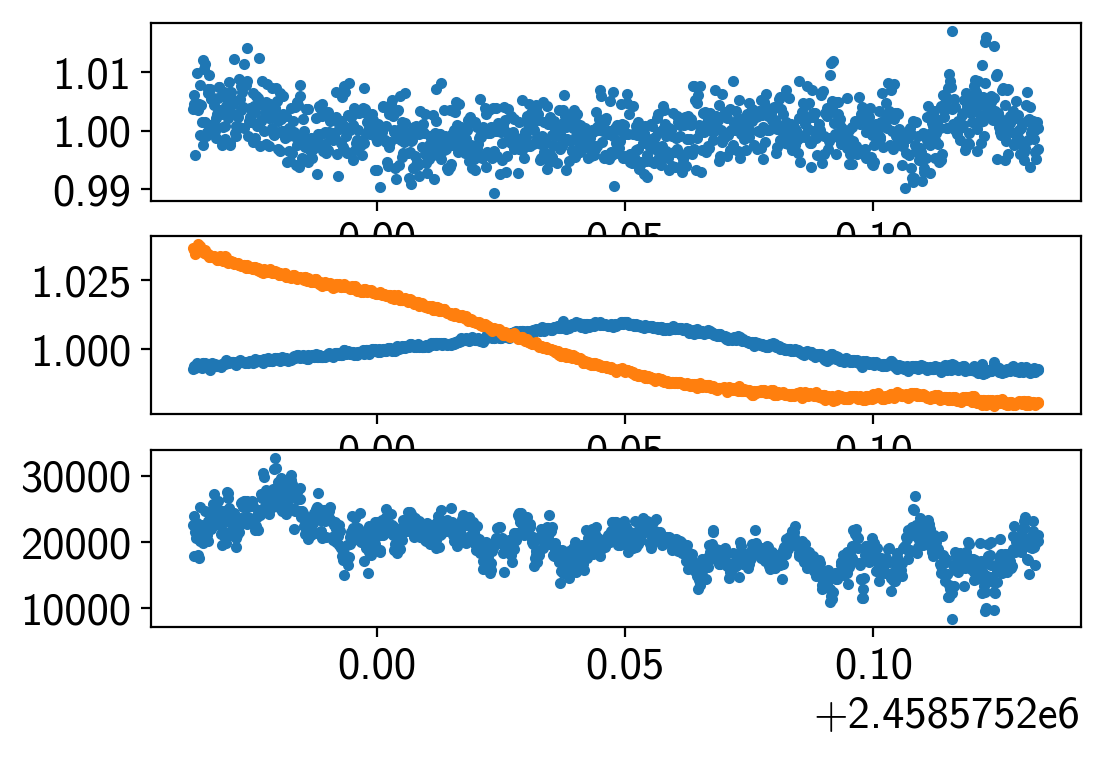

In [3]:
fp = '../data/20190401-TNT-EPIC228758948-g.txt'
df = pd.read_table(fp, delim_whitespace=True, names='t f x y peak'.split())

time, flux, cenx, ceny, peak = df.values.T

time += 2400000.5
flux /= np.median(flux)

fig, axs = pl.subplots(3, 1)
axs[0].plot(time, flux, '.')
axs[1].plot(time, cenx/cenx.mean(), '.')
axs[1].plot(time, ceny/ceny.mean(), '.')
axs[2].plot(time, peak, '.')

0


<Container object of 3 artists>

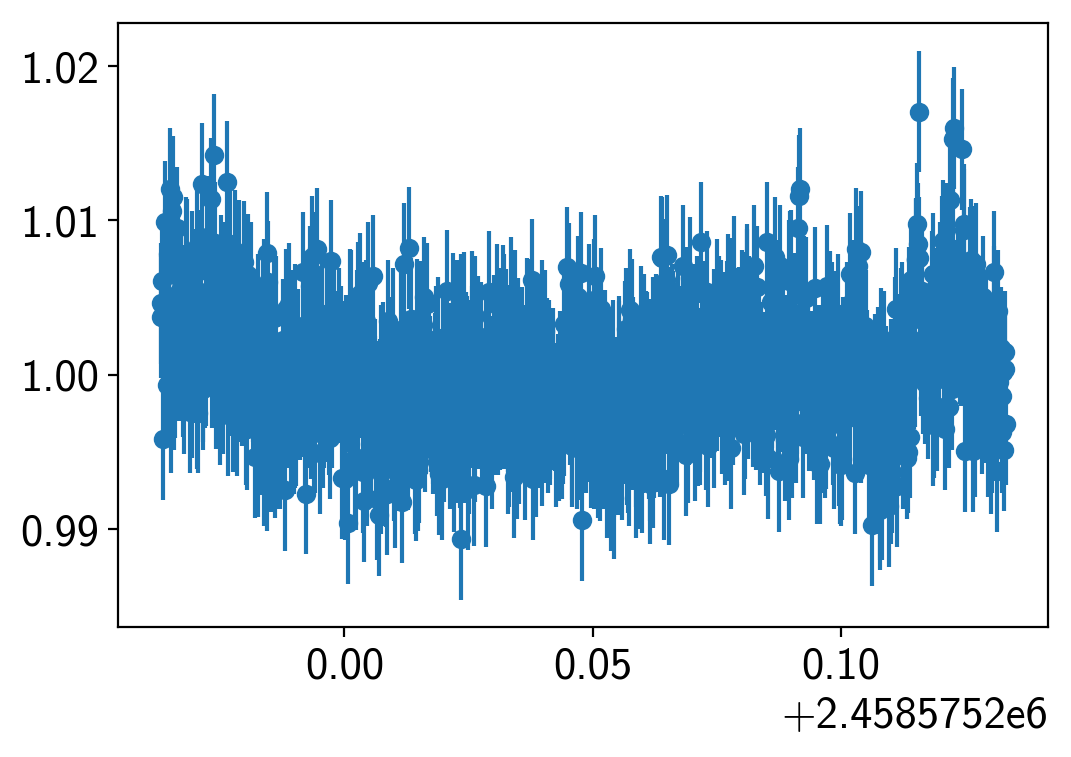

In [4]:
aux = np.c_[np.ones_like(time), time-time.min(), (time-time.min())**2, cenx/cenx.mean(), ceny/ceny.mean(), peak/peak.mean()]
# aux = np.c_[np.ones_like(time), time-time.min(), cenx/cenx.mean(), ceny/ceny.mean(), peak/peak.mean()]

idx = mad_outliers(flux)
print(idx.sum())

time, flux, aux = time[~idx], flux[~idx], aux[~idx]
unc = flux.std()

pl.errorbar(time, flux, unc, marker='o', linestyle='none')

In [5]:
# bin the data
##############

# fp = 'TOI-136_irsf_181007_j.csv'
# df = pd.read_csv(fp)

# idx = mad_outliers(df['flux'].values)
# print('omitting {} outliers'.format(idx.sum()))
# df = df[~idx]

# binsize_min = 5
# binsize = binsize_min / (60 * 24)
# print(np.diff(df['BJD_TDB']).mean()*86400)
# bins = np.arange(df['BJD_TDB'].min(), df['BJD_TDB'].max(), binsize)
# groups = df.groupby(np.digitize(df['BJD_TDB'], bins))
# df_binned = groups.mean()
# df = df_binned.copy()

# aux = df['airmass sky dx dy fwhm peak'.split()].values
# time, flux, unc = df['BJD_TDB flux err'.split()].values.T
# pl.errorbar(time, flux, unc, marker='o', linestyle='none')

In [5]:
band = 'g*'

planets = { '228758948.01': { 'per': 12.20239,
                           'rprs': 0.0370,
                           't0': 2753.8291+2454833, 
                           't14': 0.167}}

star = { 'feh': [0.11, 0.03],
            'logg': [4.45, 0.02],
            'rad': [1.03, 0.02],
            'teff': [5931, 50]}

teff, logg, feh = [star.get(k) for k in 'teff logg feh'.split()]

ldp = limbdark.claret(band, teff[0], teff[1], logg[0], logg[1], feh[0], feh[1])
u1, u2 = ldp[0], ldp[2]
q1, q2 = u_to_q(u1, u2)

# logg = map_float(star['logg'])
# rad = map_float(star['rad'])
# n = 10000
# rad_s = rad[0] + np.random.randn(n) * rad[1]
# logg_s = logg[0] + np.random.randn(n) * logg[1]
# rho_s = rho(logg_s, rad_s)
# rhop = rho_s.mean(), rho_s.std()

# priors = dict(ld=ldp, rho=rhop)

pl_name = list(planets.keys())[0]
planet = planets[pl_name]
per, t0, t14, rprs = [planet.get(key) for key in 'per t0 t14 rprs'.split()]

while t0 < time.min():
    t0 += per
    
t0p = t0, 0.0024
perp = per, 0.00072
# t14p = t14, 0.004506
# priors = dict(ld=ldp, t0=t0p, per=perp, t14=t14p)
priors = dict(ld=ldp, t0=t0p, per=perp)
# priors = None

init_params = get_init_params(per, t0, t14, rprs, b=0.5, q1=q1, q2=q2)
init_params['priors'] = priors
init_params['ls'] = np.log(flux.std())
pp.pprint(init_params)

{ 'b': 0.5,
  'k': 0.037,
  'ls': -5.534564558613325,
  'p': 12.20239,
  'priors': { 'ld': (0.528, 0.023273393615534443, 0.2391, 0.018725023527672805),
              'per': (12.20239, 0.00072),
              't0': (2458575.2226900184, 0.0024)},
  'q1': 0.58844241,
  'q2': 0.34415330465389127,
  'r': 1.41,
  't0': 2458575.2226900184,
  't14': 0.167}


In [6]:
# fit = TransitFit(init_params, pl_name, time, flux, unc=unc, aux=aux)
fit = TransitFit(init_params, pl_name, time, flux, aux=aux)

In [7]:
fit.fit_map()

Initial L-M least squares fit successful
[[Variables]]
    t0:   2.4586e+06 +/- 0        (0.00%) (init= 2458575)
    p:    12.20239 (fixed)
    k:    0.037 (fixed)
    r:    1.41 (fixed)
    b:    0.75681159 +/- 0        (0.00%) (init= 0.5)
    q1:   0.5884424 (fixed)
    q2:   0.3441533 (fixed)
    ls:  -5.534565 (fixed)
    c0:   0.53760291 +/- 0        (0.00%) (init= 0)
    c1:  -0.32171248 +/- 0        (0.00%) (init= 0)
    c2:   0.95750856 +/- 0        (0.00%) (init= 0)
    c3:  -0.13794246 +/- 0        (0.00%) (init= 0)
    c4:  -0.37248356 +/- 0        (0.00%) (init= 0)
    c5:  -0.00710335 +/- 0        (0.00%) (init= 0)
None
Transit depth: 1369 [ppm]
Transit duration: 2.96 [h]
Log-probability: 4817.28072649356
True
[[Variables]]
    t0:   2458575 (fixed)
    p:    12.20239 (fixed)
    k:    0.037 (fixed)
    r:    1.41 (fixed)
    b:    0.86528450 (init= 0.7568116)
    q1:   0.5884424 (fixed)
    q2:   0.3441533 (fixed)
    ls:  -5.64187527 (init=-5.534565)
    c0:   0.15538063

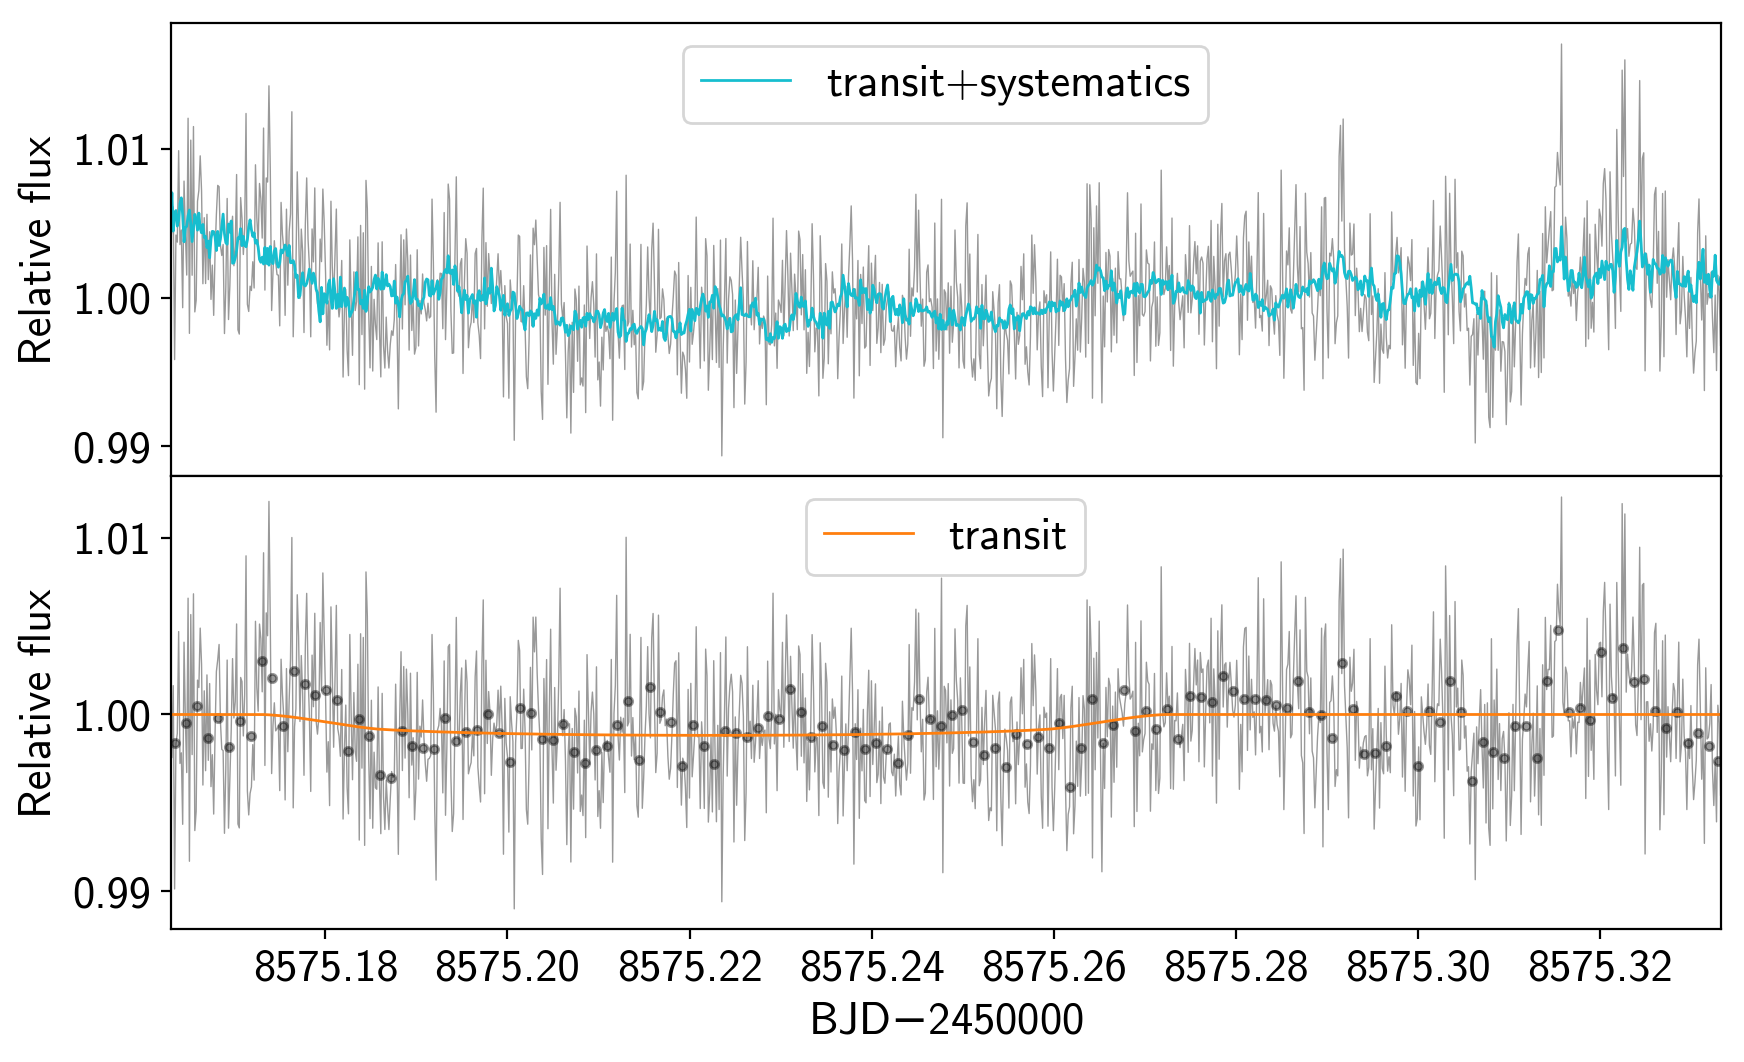

In [8]:
fit.plot_map()

In [9]:
# fit.fit_mcmc(two_stage=True)
fit.fit_mcmc(two_stage=True, steps=2000, nproc=4)

Running stage 1 MCMC (250 steps)...
Running production MCMC for 2000 steps...
[[Variables]]
    t0:   2.4586e+06 +/- 0.001805 (0.00%) (init= 2458575)
    p:    12.2023749 +/- 0.000782 (0.01%) (init= 12.20239)
    k:    0.05046758 +/- 0.009094 (18.02%) (init= 0.037)
    r:    5.20346196 +/- 4.050965 (77.85%) (init= 1.41)
    b:    0.60164990 +/- 0.317517 (52.77%) (init= 0.8652845)
    q1:   0.58789044 +/- 0.042707 (7.26%) (init= 0.5884424)
    q2:   0.34443726 +/- 0.009743 (2.83%) (init= 0.3441533)
    ls:  -5.64289118 +/- 0.020983 (0.37%) (init=-5.641875)
    c0:  -0.15741579 +/- 0.259675 (164.96%) (init= 0.1553806)
    c1:  -0.18261829 +/- 0.073842 (40.44%) (init=-0.2672191)
    c2:   0.84823755 +/- 0.184311 (21.73%) (init= 1.040026)
    c3:   0.21000086 +/- 0.128056 (60.98%) (init= 0.0563979)
    c4:  -0.03707741 +/- 0.131942 (355.86%) (init=-0.190418)
    c5:  -0.00806052 +/- 0.000858 (10.65%) (init=-0.007889984)
None
FIT_MCMC elapsed time: 148 sec


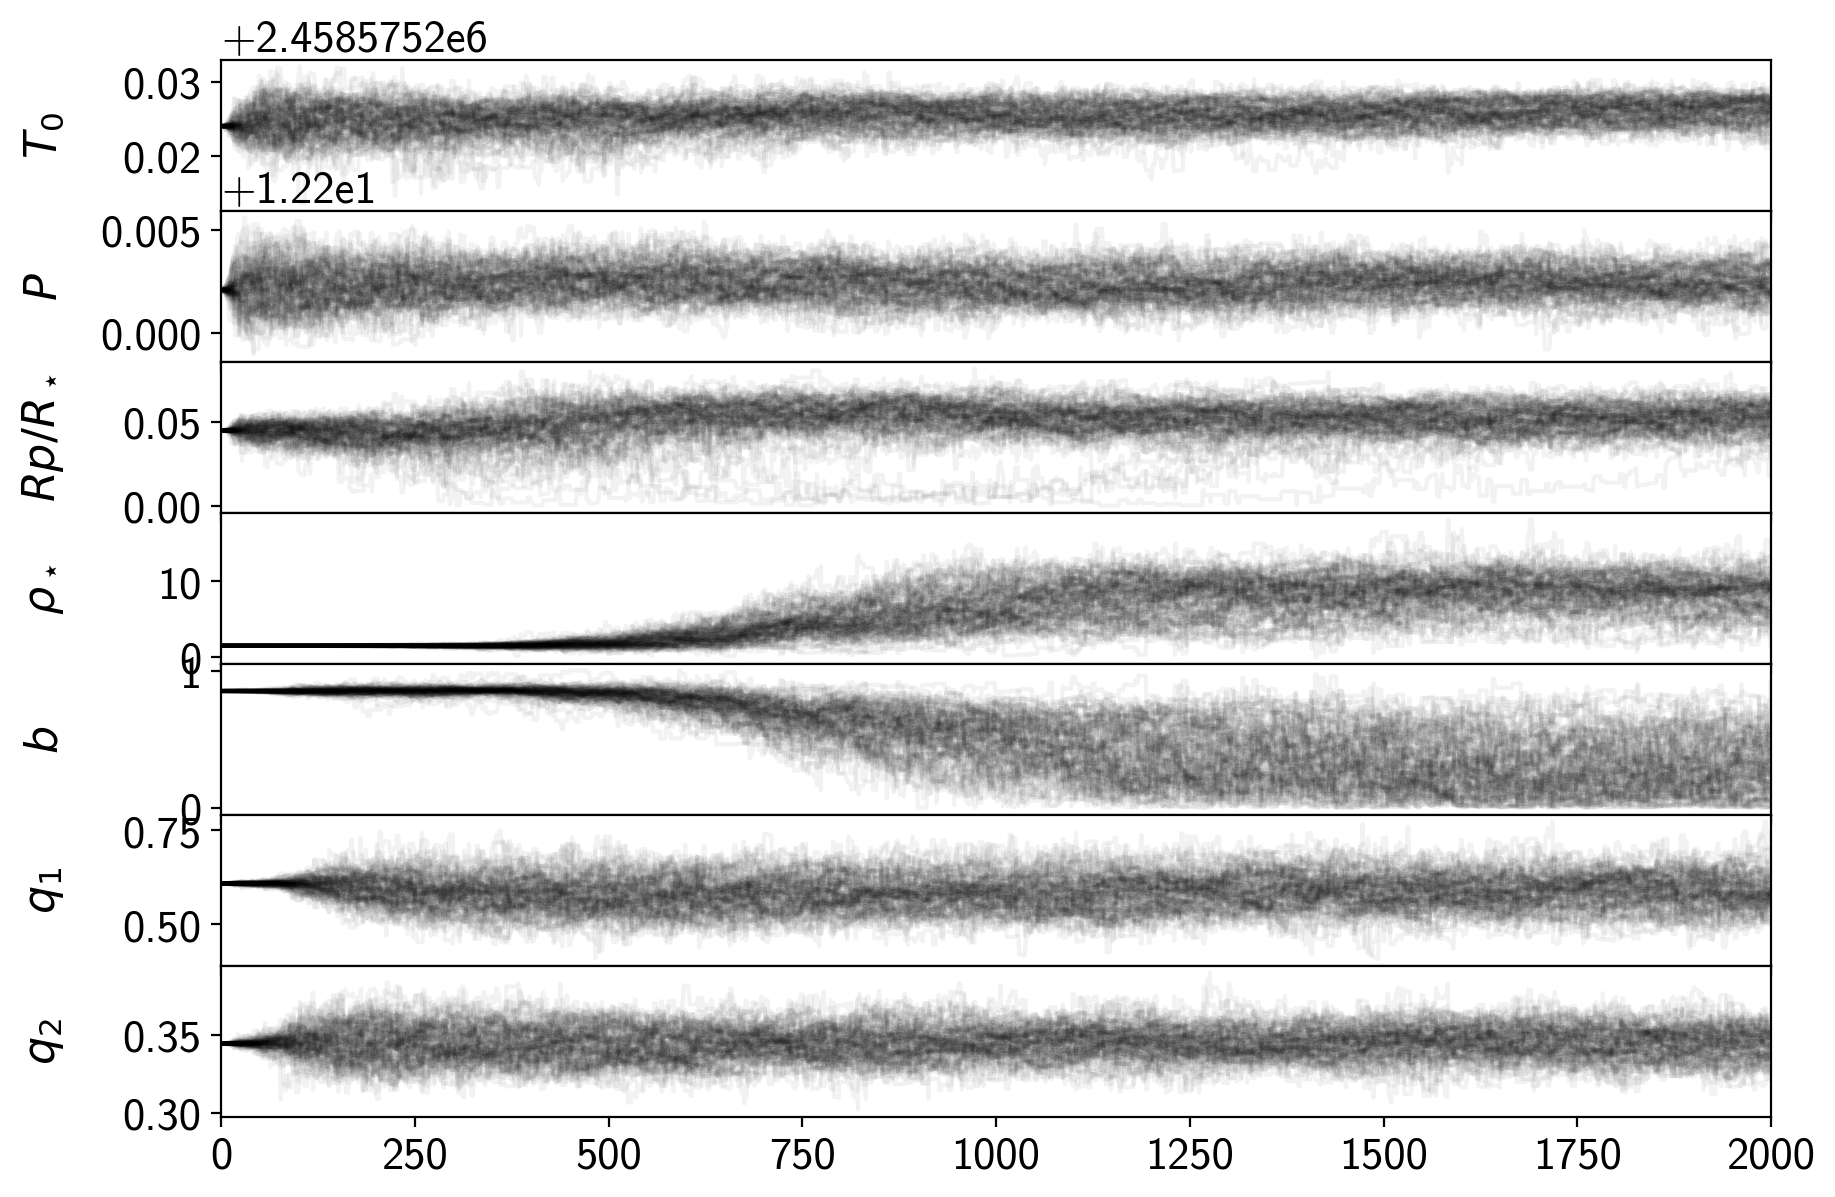

In [10]:
fit.plot_trace()

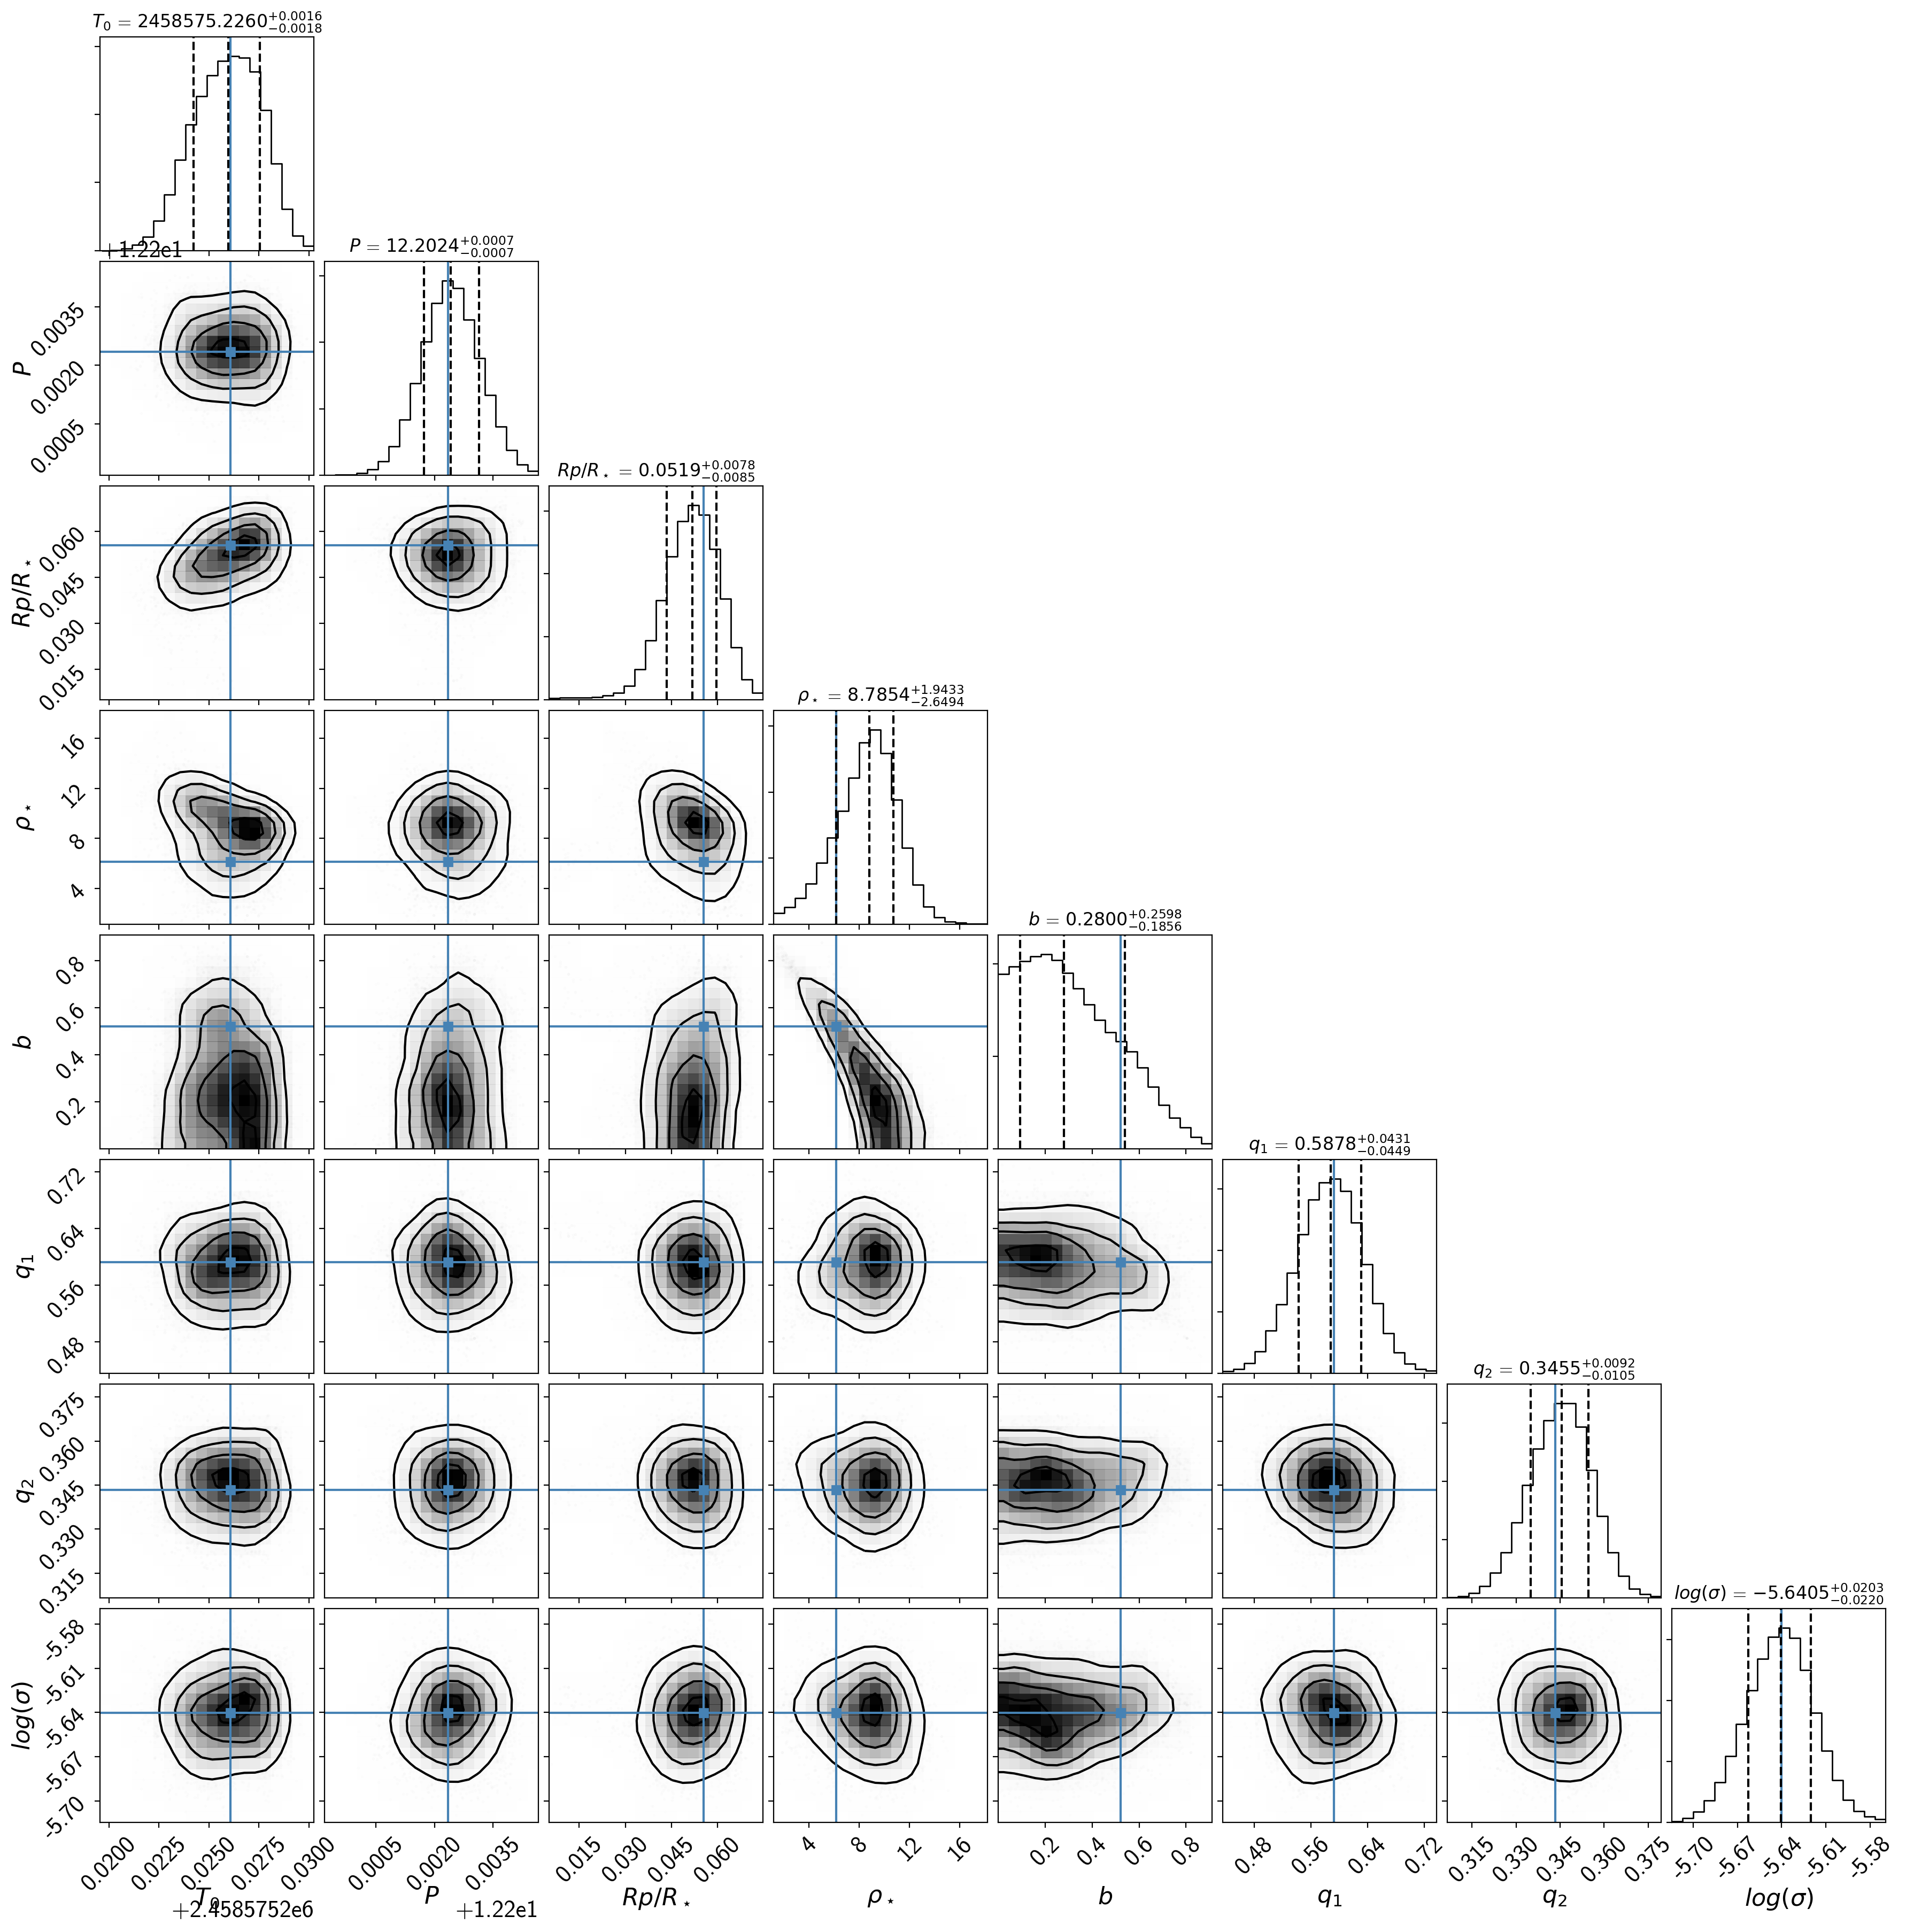

In [11]:
fit.burn_thin(burn=1500, thin=10)
fit.plot_corner()

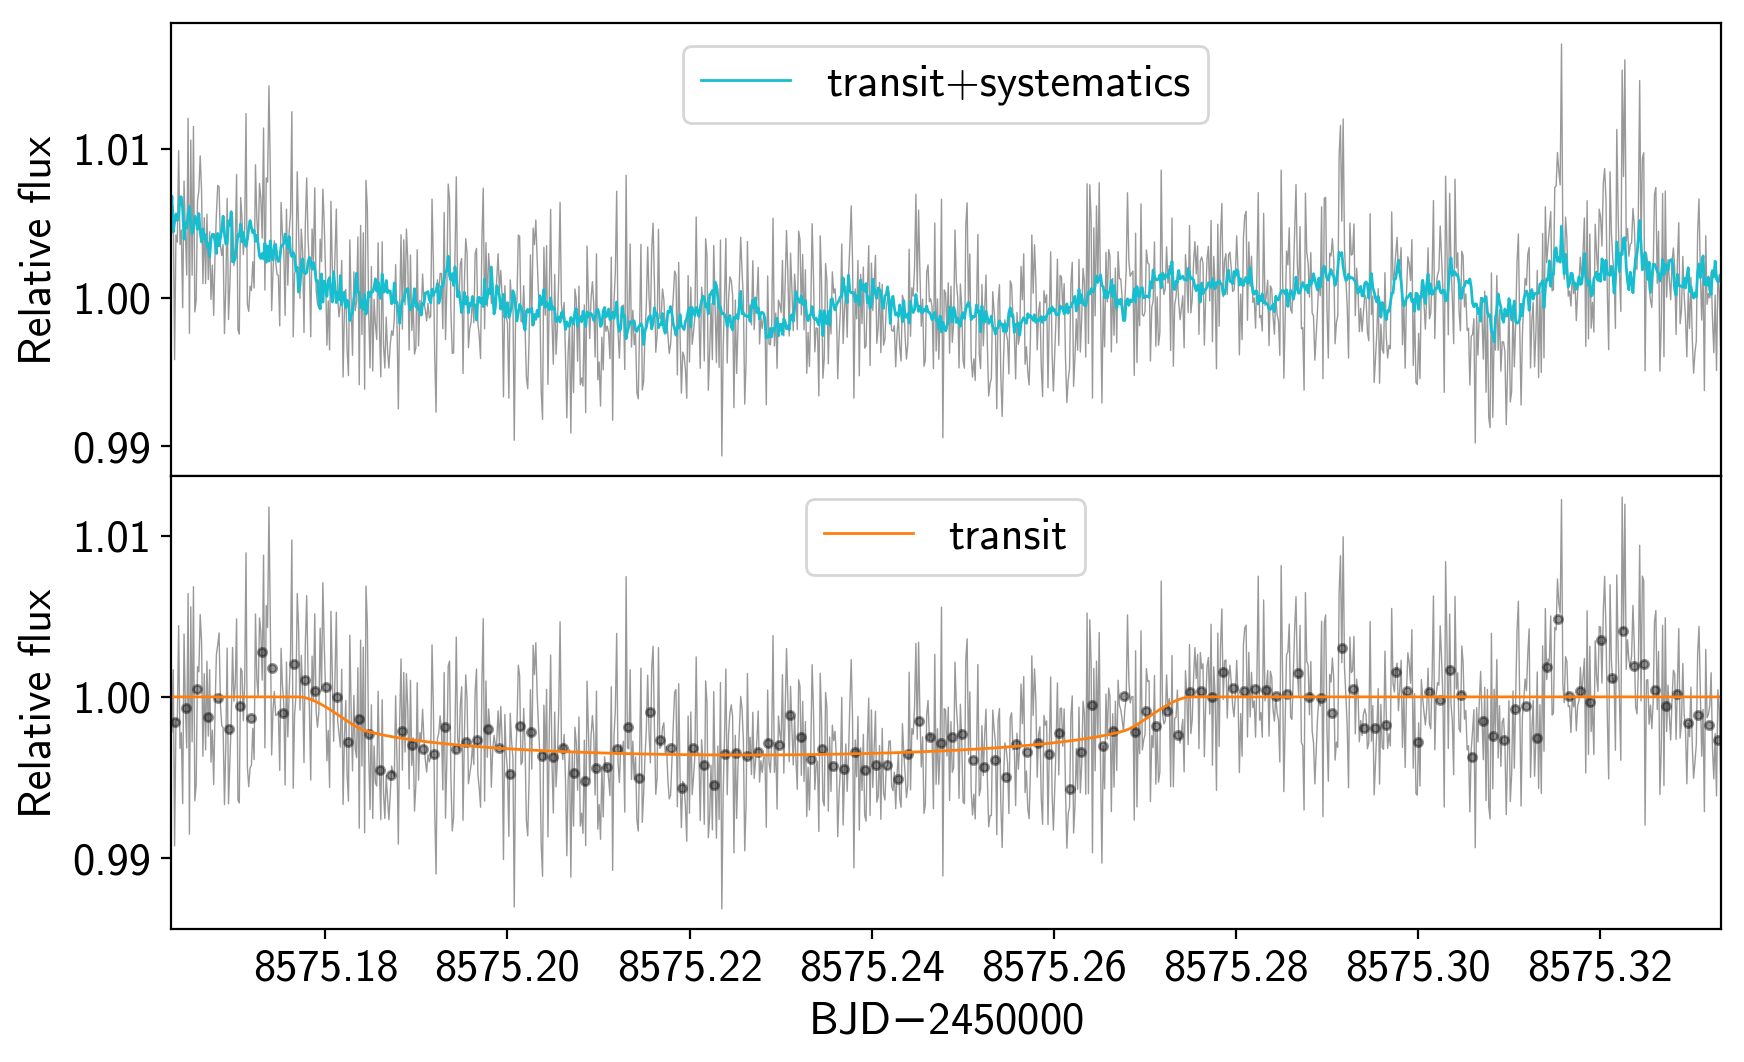

In [12]:
fit.plot_map()

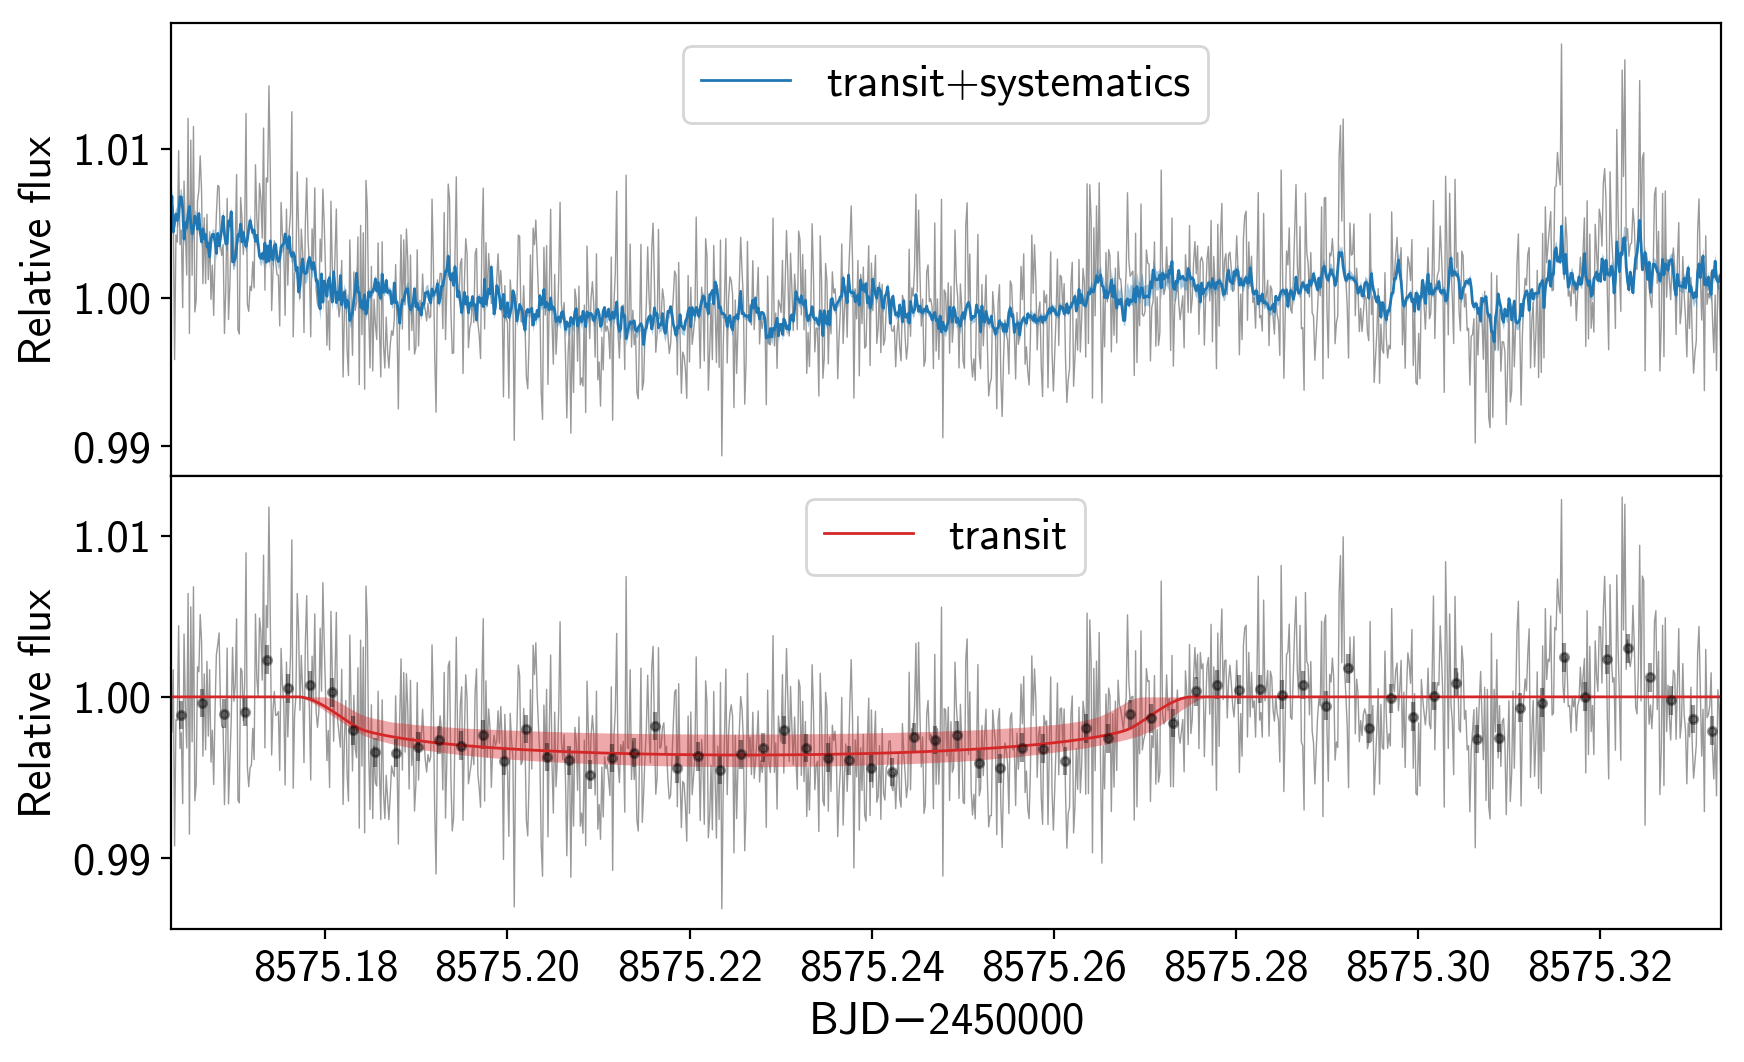

In [16]:
fig, axs = pl.subplots(2, 1, figsize=(10,6), sharex=True, sharey=False)
fit.plot_mcmc(binsize=16, c1='C0', c2='C3', sig=1, axs=axs)
# pl.setp(axs[1], ylim=(0.85,1.05))

In [17]:
fit.get_df(*star['rad']).describe()

t0            p            k            r            b  \
count  5.000000e+03  5000.000000  5000.000000  5000.000000  5000.000000   
mean   2.458575e+06    12.202425     0.051376     8.510639     0.309347   
std    1.572612e-03     0.000700     0.008660     2.352538     0.201235   
min    2.458575e+06    12.199185     0.005180     1.172930     0.000010   
25%    2.458575e+06    12.201958     0.046225     7.066030     0.146269   
50%    2.458575e+06    12.202416     0.051923     8.785413     0.280043   
75%    2.458575e+06    12.202898     0.057407    10.089662     0.453313   
max    2.458575e+06    12.204662     0.074841    18.203281     0.910442   

                q1           q2           ls           c0           c1  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean      0.587250     0.345022    -5.640986    -0.261773    -0.153525   
std       0.043856     0.009871     0.021285     0.210808     0.059294   
min       0.435456     0.306600    -5.714540    -0.891602    -0.381253   
25%       0.558127     0.338382    -5.655430    -0.406607    -0.190191   
50%       0.587832     0.345481    -5.640517    -0.266661    -0.151856   
75%       0.616941     0.351841    -5.626900    -0.122425    -0.113957   
max       0.737591     0.379434    -5.569334     0.562170     0.058101   

          ...                c4           c5        rstar       pl_rad  \
count     ...       5000.000000  5000.000000  5000.000000  5000.000000   
mean      ...          0.013666    -0.008098     1.029889     5.771187   
std       ...          0.104068     0.000873     0.019909     0.978633   
min       ...         -0.395472    -0.011258     0.947290     0.575776   
25%       ...         -0.049665    -0.008661     1.016293     5.197879   
50%       ...          0.017113    -0.008100     1.029817     5.841896   
75%       ...          0.082876    -0.007533     1.043350     6.443956   
max       ...          0.409277    -0.004839     1.101610     8.344066   

                 a          inc          t14          t23        shape  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean     40.200641    89.523349     0.095110     0.083910     0.883272   
std       4.174302     0.374799     0.004950     0.003877     0.035739   
min      20.977952    87.607248     0.049486     0.045525     0.591348   
25%      38.170548    89.319116     0.091951     0.081512     0.873072   
50%      41.044927    89.614706     0.095756     0.084227     0.890914   
75%      42.984678    89.807131     0.098539     0.086671     0.903931   
max      52.325770    89.999987     0.114127     0.094526     0.981634   

             max_k  
count  5000.000000  
mean      0.062381  
std       0.021067  
min       0.009268  
25%       0.050458  
50%       0.057690  
75%       0.067764  
max       0.256796  

[8 rows x 22 columns]

dilution if on secondary
--

In [30]:
mag_companion = 15.89
mag_target = 12.87
delta = mag_companion - mag_target
gamma = 1 + 10**(0.4*delta)
gamma

17.143585568264886

In [31]:
best_k = fit.best[fit.parameter_names.index('k')]
np.sqrt(best_k**2 / gamma), best_k

(0.013413100410188231, 0.0555366917030004)

In [32]:
best_k / np.sqrt(gamma)

0.013413100410188233

dilution if on primary
--

In [33]:
gamma = 1 + 10**(0.4*-delta)
gamma

1.061944107507678

In [34]:
best_k / np.sqrt(gamma)

0.05389260489807782

neither agrees with K2 value: 0.0370
--